# NMF for music transcription 

In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, urllib, IPython.display as ipd
import librosa, librosa.display

## C major scale

Resource for sound files 
https://ccrma.stanford.edu/~mromaine/220a/fp/sound-examples.html

In [2]:
x, sr = librosa.load('eqt-major-sc.wav', sr=44100)

In [3]:
ipd.Audio(x, rate=sr)

Compute the STFT:

In [4]:
# stft with default hop length and window size 
# hop length = 512
S = librosa.stft(x)

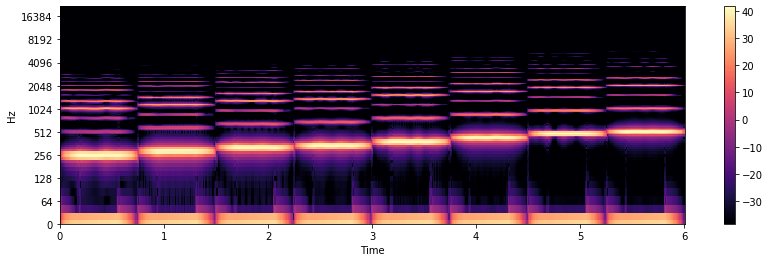

In [5]:
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## Decompose into harmonic and percussive parts of the STFT

In [6]:
# decompose the harmonic and percussive parts 
S_harmonic, S_percussive = librosa.decompose.hpss(S)

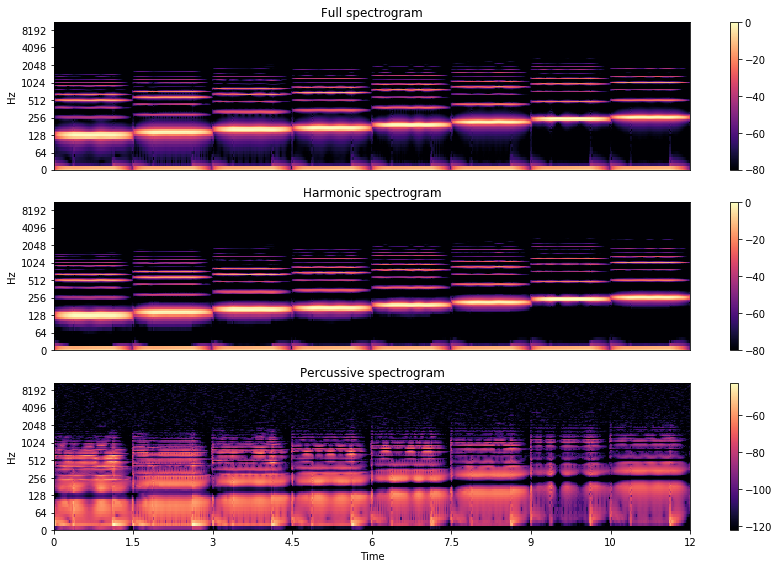

In [7]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(S))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(S), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_harmonic), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_percussive), ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

### NMF decomposition

8 spectral templates for the 8 notes 

In [8]:
# seperate the harmonic STFT into magnitude and phase
X, X_phase = librosa.magphase(S_harmonic)

# Here we set n_components to 7 which corresponds to the 
# number of pitch classes in the major scale 
n_components = 8

# NMF decomposition 
W, H = librosa.decompose.decompose(X, n_components=n_components, sort=True)

print(W.shape)
print(H.shape)

(1025, 8)
(8, 517)


Let's display the spectral profiles:

C:\Users\olli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


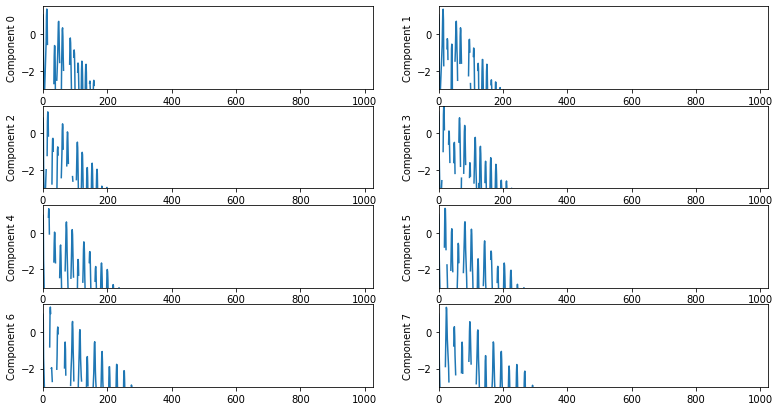

In [9]:
plt.figure(figsize=(13, 7))
logW = np.log10(W)
for n in range(n_components):
    plt.subplot(np.ceil(n_components/2.0), 2, n+1)
    plt.plot(logW[:,n])
    plt.ylim(-3, logW.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)

# Find the frequency of the components ? 

The components are simply DFT representations of each note that has been played

In [10]:
from __future__ import division

# parabolic interpolation to increase accuracy of peak picking 
def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
    """
    # Requires real division.  Insert float() somewhere to force it?
    xv = 1/2 * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4 * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

In [11]:
# naive peak picking for spectral components 
def freq_from_dft(dft):
    i = np.argmax(abs(dft))
    true_i = parabolic(np.log(dft),i)[0]
    
    return sr*true_i/len(dft)

In [12]:
# find the fundamental frequency of each component using parabolic interpolation 

for n in range(n_components):
    
    freq_est = freq_from_dft(W[:,n])
    print('component ',n, ': ',freq_est,'Hz')

component  0 :  522.4566859609201 Hz
component  1 :  586.4371556934111 Hz
component  2 :  657.6244176066934 Hz
component  3 :  700.035330881217 Hz
component  4 :  784.4475230181555 Hz
component  5 :  878.925157708884 Hz
component  6 :  986.6430052975205 Hz
component  7 :  1048.4868112989916 Hz


C:\Users\olli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Let's display the temporal activations, $\{h_1, ..., h_R\}$:

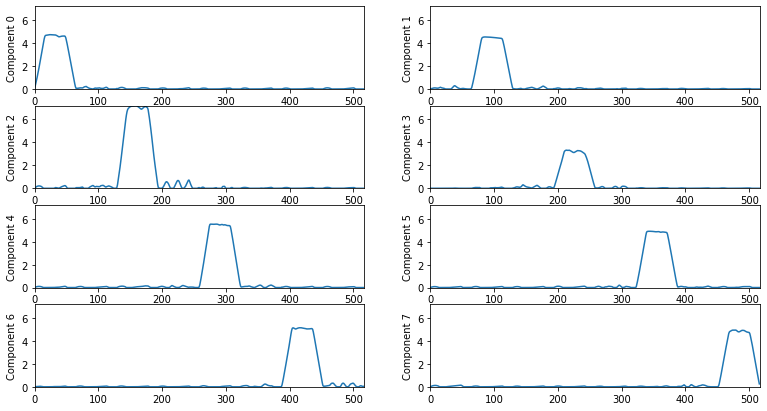

In [13]:
plt.figure(figsize=(13, 7))
for n in range(n_components):
    plt.subplot(np.ceil(n_components/2.0), 2, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

Finally, re-create the individual components, and listen to them. To do this, we will reconstruct the magnitude spectrogram from the NMF outputs and use the phase spectrogram from the original signal.

In [14]:
for n in range(n_components):
    
    # Re-create the STFT of a single NMF component.
    Y = scipy.outer(W[:,n], H[n])*X_phase
    
    # Transform the STFT into the time domain.
    y = librosa.istft(Y)
    
    print('Component {}:'.format(n))
    ipd.display( ipd.Audio(y, rate=sr) )

Component 0:


Component 1:


Component 2:


Component 3:


Component 4:


Component 5:


Component 6:


Component 7:


Listen to the reconstructed full mix:

In [15]:
# Re-create the STFT from all NMF components.
Y = np.dot(W, H)*X_phase

# Transform the STFT into the time domain.
reconstructed_signal = librosa.istft(Y, length=len(x))
ipd.Audio(reconstructed_signal, rate=sr)

Listen to the residual:

In [16]:
residual = x - reconstructed_signal
residual[0] = 1 # hack to prevent automatic gain scaling
ipd.Audio(residual, rate=sr)